## Import dependencies

In [127]:
import pandas as pd
import seaborn as sns
import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import joblib

## Read data

In [128]:
X_train = pd.read_csv("../data/train_test/X_train.csv",header=None)
X_test = pd.read_csv("../data/train_test/X_test.csv", header=None)
y_train = pd.read_csv("../data/train_test/y_train.csv", header=None)
y_test = pd.read_csv("../data/train_test/y_test.csv", header=None)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().reshape(-1,)
y_test = y_test.to_numpy().reshape(-1,)

## Build pipeline

### Select classifier 

First, I test some classifier, than I can choose one for parameter optimization to get better results.

In [129]:

knc = KNeighborsClassifier()
lr = LogisticRegression(solver="newton-cg")
svc = SVC()
rfc = RandomForestClassifier()
nbc = MultinomialNB()
#gbc = GradientBoostingClassifier()
bc = BaggingClassifier()

ml_models = models = {"knc": knc, "lr": lr, "svc": svc, "rfc": rfc,
                      'nb' : MultinomialNB(),
                       'bc' : BaggingClassifier()}

In [130]:
def initial_model(X_train, X_test, y_train, y_test, ml_models):
    
    
    
    for model in ml_models:
          
        if model != 'nb':
            
            pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                     ('scaler', StandardScaler()), (model, ml_models[model])])
        else:
            
            pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                     ('minmax',MinMaxScaler()), (model, ml_models[model])])
        
        start_train = time.time()
        pipe.fit(X_train, y_train)
        train_time = round(time.time()-start_train,1)
        
        accuracy = accuracy_score(y_test,pipe.predict(X_test))
        recall = recall_score(y_test,pipe.predict(X_test), average=None)
        precision = precision_score(y_test,pipe.predict(X_test), average=None)
        f1 = f1_score(y_test,pipe.predict(X_test), average=None)
        
        print('*'*20)
        print(f'Scores of {model}:')
        print('*'*20)
        print(f'Train time: {train_time}s')
        print(f'Accuracy score: {accuracy}')
        print('\n')
        print(f'Recall score: {recall}')
        print('\n')
        print(f'Precision score: {precision}')
        print('\n')
        print(f'F1 score: {f1}')
        print('\n')
    

In [131]:
initial_model(X_train,X_test,y_train,y_test,ml_models)

********************
Scores of knc:
********************
Train time: 0.4s
Accuracy score: 0.9391714735186156


Recall score: [0.99293286 0.96323529 0.97131148 0.86956522 0.92899408 0.99375
 0.88461538 0.82352941 0.9        1.         0.68571429 0.36842105]


Precision score: [0.93666667 0.98867925 0.9916318  0.91872792 0.88700565 1.
 0.95833333 0.82352941 0.72972973 0.68571429 0.85714286 1.        ]


F1 score: [0.96397942 0.97579143 0.98136646 0.89347079 0.90751445 0.9968652
 0.92       0.82352941 0.80597015 0.81355932 0.76190476 0.53846154]


********************
Scores of lr:
********************
Train time: 4.9s
Accuracy score: 0.9716832721552177


Recall score: [0.99646643 0.99632353 0.99180328 0.93311037 0.94970414 1.
 1.         1.         0.83333333 0.91666667 0.94285714 0.78947368]


Precision score: [0.99295775 0.99632353 0.99588477 0.94256757 0.94134897 1.
 1.         0.94444444 0.96153846 0.88       0.86842105 0.83333333]


F1 score: [0.99470899 0.99632353 0.99383984 0.9378

## Final model

In the initial test, in the previous section I tried out some of the classification models in sklearn. There are some model with really high accuracy. Most of the models without any parameter tuning, show us a high accuracy. The fastest model was the `Naive Bayes` but the accuracy wasn't so high. The `Random Forest Classifier` has the highest accuracy score, and the calculation speed is not so bad. I will test out this model. 

### RandomForestClassifier 

In [132]:
rfc_params = {'rfc__n_estimators' : [100],
              'rfc__max_depth' : [2, 20, 50],
              'rfc__min_samples_split' : [2, 5, 10],
              'rfc__min_samples_leaf' : [1, 2, 10]} 

In [133]:
 def random_search(model, params):
        
    pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                     ('scaler', StandardScaler()), ("rfc", model)])
                     
    search = GridSearchCV(pipe, param_grid=params)
    
    return search

In [134]:
model = random_search(RandomForestClassifier(),rfc_params)

In [135]:
model.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('imputer', SimpleImputer(fill_value=0)),
                                       ('scaler', StandardScaler()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__max_depth': [2, 20, 50],
                         'rfc__min_samples_leaf': [1, 2, 10],
                         'rfc__min_samples_split': [2, 5, 10],
                         'rfc__n_estimators': [100]})

In [136]:
model.best_params_

{'rfc__max_depth': 50,
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 2,
 'rfc__n_estimators': 100}

In [142]:
start_train = time.time()
train_time = round(time.time()-start_train,1)

accuracy = accuracy_score(y_test,model.predict(X_test))
recall = recall_score(y_test,model.predict(X_test), average=None)
precision = precision_score(y_test,model.predict(X_test), average=None)
f1 = f1_score(y_test,model.predict(X_test), average=None)

print('*'*20)
print(f'Scores of {model}:')
print('*'*20)
print(f'Train time: {train_time}s')
print(f'Accuracy score: {accuracy}')
print('\n')
print(f'Recall score: {recall}')
print('\n')
print(f'Precision score: {precision}')
print('\n')
print(f'F1 score: {f1}')
print('\n')
    

********************
Scores of GridSearchCV(estimator=Pipeline(steps=[('imputer', SimpleImputer(fill_value=0)),
                                       ('scaler', StandardScaler()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__max_depth': [2, 20, 50],
                         'rfc__min_samples_leaf': [1, 2, 10],
                         'rfc__min_samples_split': [2, 5, 10],
                         'rfc__n_estimators': [100]}):
********************
Train time: 0.0s
Accuracy score: 0.9790246460409019


Recall score: [1.         0.98529412 0.99180328 0.97324415 0.97337278 1.
 0.92307692 1.         0.93333333 0.83333333 0.88571429 0.73684211]


Precision score: [0.98606272 1.         0.99180328 0.96677741 0.97337278 1.
 0.92307692 0.94444444 0.875      0.83333333 0.93939394 0.875     ]


F1 score: [0.99298246 0.99259259 0.99180328 0.97       0.97337278 1.
 0.92307692 0.97142857 0.90322581 0.83333333 0.91176471 0.8       ]




In [104]:
scores = cross_val_score(model, X_train, y_train, cv=3)

In [105]:
print('Accuracy of the model: {}% ±{}%'.format(round(np.mean(scores)*100,2), round(np.std(scores)*100,2)))

Accuracy of the model: 91.48% ±0.5%


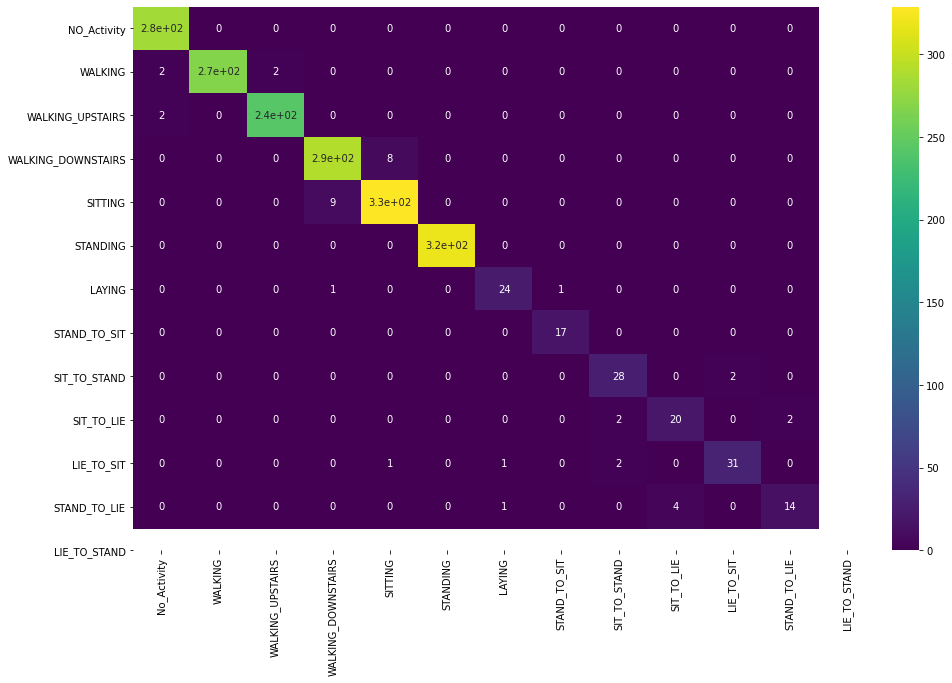

In [138]:
plt.figure(figsize=(16,10))
sns.heatmap(confusion_matrix(y_test,model.predict(X_test)), annot=True, cmap="viridis",
            xticklabels=["No_Activity","WALKING",
                       "WALKING_UPSTAIRS",
                       "WALKING_DOWNSTAIRS",
                       "SITTING",
                       "STANDING",
                       "LAYING",
                       "STAND_TO_SIT",
                       "SIT_TO_STAND",
                       "SIT_TO_LIE",
                       "LIE_TO_SIT",
                       "STAND_TO_LIE",
                       "LIE_TO_STAND"],
            yticklabels=['NO_Activity',"WALKING",
                       "WALKING_UPSTAIRS",
                       "WALKING_DOWNSTAIRS",
                       "SITTING",
                       "STANDING",
                       "LAYING",
                       "STAND_TO_SIT",
                       "SIT_TO_STAND",
                       "SIT_TO_LIE",
                       "LIE_TO_SIT",
                       "STAND_TO_LIE",
                       "LIE_TO_STAND"])

###  Saving the final model

In [139]:
import joblib

In [143]:
def save_model(model):
    '''Save the model to disk'''
    
    filename = '../models/har_model_v12.sav'
    joblib.dump(model, filename)
    readme = open('../models/ml_model_v09.txt', 'w')
    readme.write('Ml model with svc, without overlap 97% accuracy.')
    readme.close()

In [144]:
save_model(model)

In [145]:
features_to_drop

[('acc_x_FFT', 'peak_mean_6'),
 ('acc_x_FFT', 'peak_mean_8'),
 ('acc_x_FFT', 'peak_mean_12'),
 ('acc_y_FFT', 'peak_mean_6'),
 ('acc_y_FFT', 'peak_mean_8'),
 ('acc_y_FFT', 'peak_mean_12'),
 ('acc_z_FFT', 'peak_mean_6'),
 ('acc_z_FFT', 'peak_mean_8'),
 ('acc_z_FFT', 'peak_mean_12'),
 ('gyro_x_FFT', 'peak_mean_6'),
 ('gyro_x_FFT', 'peak_mean_8'),
 ('gyro_x_FFT', 'peak_mean_12'),
 ('gyro_y_FFT', 'peak_mean_6'),
 ('gyro_y_FFT', 'peak_mean_8'),
 ('gyro_y_FFT', 'peak_mean_12'),
 ('gyro_z_FFT', 'peak_mean_6'),
 ('gyro_z_FFT', 'peak_mean_8'),
 ('gyro_z_FFT', 'peak_mean_12')]